<img src="https://upload.wikimedia.org/wikipedia/en/5/5e/Munster_Technological_University_Logo%2C_2021.jpg">

#Applied Machine Learning (Dr. Haithem Afli) – Project 1 Assignment - Spam Classifier
##Orlando Jr R00224938


<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/spam.jpg"/>

## Introduction
###This project will explore the Enron email dataset, a public dataset that classified all messages as "SPAM" and "NON-SPAM", here called "HAM". The aim is also split the dataset in Train and Test, display some information in the EDA and finally create a supervised classification pipeline.
###This notebook will be commented in form to explain the most important steps and intentionally works like a report.

###The files and codes are stored in the following address: https://github.com/orlandojrps/spam

#Importing Libraries and Packages
<img src ="https://raw.githubusercontent.com/orlandojrps/spam/main/lib.png">

In [ ]:
import zipfile
import urllib.request
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import sklearn.naive_bayes 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
import spacy 
from tqdm.notebook import tqdm as PROG_BAR 
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!python -m spacy download en_core_web_lg

#Preprocessing

<img src ="https://raw.githubusercontent.com/orlandojrps/spam/main/load.png"/>

##Extract, Load, Transform
####The emails are stored in a zip file, separeted into 2 folders. To make acessible to further studies the dataset was uploaded to a Github folder. The emails will be loaded from the zip to a Dataframe.

In [ ]:
file = "https://github.com/orlandojrps/spam/blob/8ab6bd3c9f131cc57a6664a5e16879b779dc157d/enron1.zip?raw=true"
name, headers = urllib.request.urlretrieve(file, 'enron1.zip')

with zipfile.ZipFile(name, 'r') as zip_ref:
  zip_ref.extractall('')

emails = []
for folder in ['ham', 'spam']:
    path = 'enron1/{}'.format(folder)
    for file in os.listdir(path):
        with open('{}/{}'.format(path, file), 'r', encoding='ISO-8859-1') as f:
            content = f.read()
        emails.append({'message': content, 'classification': folder})

df = pd.DataFrame(emails)


###Inspecting content of the Dataset:

In [ ]:
df

,message,classification
0,Subject: 3 rd party expense contracts\nmick\n3...,ham
1,Subject: 2 / 5 / 01 gas flow day\nwe agree wit...,ham
2,Subject: re : atmic hurta # 1 - new production...,ham
3,Subject: re : nom / actual volume for april 16...,ham
4,Subject: hpl / enron nom . for 11 / 01 / 00\n(...,ham
...,...,...
5167,Subject: coming over tomorrow ?\nsome suspect ...,spam
5168,Subject: new product ! cialis soft tabs .\nhi ...,spam
5169,Subject: confirm your online banking account\n...,spam
5170,Subject: shopping for [ mortgages ] made easy\...,spam


In [ ]:
df.shape

(5172, 2)

####Extraction and Loading well succeeded! Our dataset has 2 Columns (Message and Classification) with a total of 5172 observations (rows) 

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/cleaning.jpg">

###Let's checking for missing values, repeaded observations and remove from ourdataset if present

In [ ]:
df.isnull().sum()

message           0
classification    0
dtype: int64

In [ ]:
df.isna().sum()

message           0
classification    0
dtype: int64

In [ ]:
df.duplicated().sum()

178

####No missing values but 178 occurrences of repeated observations. Let's explore a little more and check those messages, next step is drop the repetitions:

In [ ]:
df[df. duplicated()]

,message,classification
375,Subject: cleburne\ncleburne should be it ' s o...,ham
425,Subject: calpine daily gas nomination\n>\nrick...,ham
497,Subject: cornhusker for sept\ni was informed b...,ham
522,"Subject: estimated actuals for april 5 , 2001\...",ham
648,Subject: calpine daily gas nomination\n>\nrick...,ham
...,...,...
4966,Subject: cheap soft cialis tabs\nthese pills a...,spam
5050,Subject: \ntor 0 nto\nrx\ntop\n10 medications ...,spam
5069,Subject: \n,spam
5086,Subject: new product ! cialis soft tabs .\nhi ...,spam


In [ ]:
df.drop_duplicates()

,message,classification
0,Subject: 3 rd party expense contracts\nmick\n3...,ham
1,Subject: 2 / 5 / 01 gas flow day\nwe agree wit...,ham
2,Subject: re : atmic hurta # 1 - new production...,ham
3,Subject: re : nom / actual volume for april 16...,ham
4,Subject: hpl / enron nom . for 11 / 01 / 00\n(...,ham
...,...,...
5167,Subject: coming over tomorrow ?\nsome suspect ...,spam
5168,Subject: new product ! cialis soft tabs .\nhi ...,spam
5169,Subject: confirm your online banking account\n...,spam
5170,Subject: shopping for [ mortgages ] made easy\...,spam


####Now the clean Dataset has the format of 4994 row with 2 columns.

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/train_test.jpg">

#Train and Test Split
The dataset will be divided into Train with 70% and test with 30% of the observations. To this task it ill be used the method "train_test_split" from Sklearn. To avoid Bias in the sampling process it will be used a parameter called "stratify" to keep the proportion of classes in the train part similar to the original dataset.

###First it's important to check the proportion of classes (Spam - Ham) in the original dataset, to compare later with the dataset divided to make sure that the proportion was mantained.

In [ ]:
print("Original dataset statistics:")
print(f"Total emails: {len(df)}")
print(f"Spam emails: {len(df[df['classification'] == 'spam'])}")
print(f"Non-spam emails: {len(df[df['classification'] == 'ham'])}")
print(f"Spam ratio: {len(df[df['classification'] == 'spam'])/len(df)}")

Original dataset statistics:
Total emails: 5172
Spam emails: 1500
Non-spam emails: 3672
Spam ratio: 0.2900232018561485


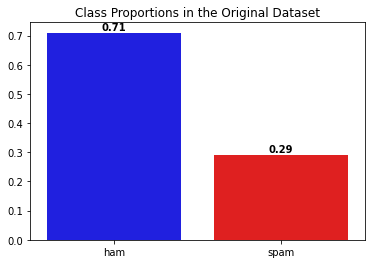

In [ ]:
class_prop = df['classification'].value_counts(normalize=True)
ax=sns.barplot(x=class_prop.index, y=class_prop.values, palette=['blue', 'red'])
for i, v in enumerate(class_prop.values):
    ax.text(i, v + 0.01, str(round(v, 2)), ha='center', fontweight='bold')
plt.title('Class Proportions in the Original Dataset');


###Spliting Dataset:

In [ ]:
# define a feature do modelo
X = df.message.values.reshape(-1, 1)
# define a target do modelo
y = df.classification.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=df["classification"], random_state=4938)


#train, test = train_test_split(df, test_size=0.3, stratify=df["classification"], random_state=4938)

####Verifying the results:

In [ ]:
y_train

array([['ham'],
       ['ham'],
       ['ham'],
       ...,
       ['ham'],
       ['ham'],
       ['spam']], dtype=object)

In [ ]:
train_spam = y_train[y_train== "spam"]
train_non_spam = y_train[y_train== "ham"]
test_spam = y_test[y_test == "spam"]
test_non_spam = y_test[y_test == "ham"]

print("Training set statistics:")
print(f"Total emails: {len(y_train)}")
print(f"Spam emails: {len(train_spam)}")
print(f"Non-spam emails: {len(train_non_spam)}")
print(f"Spam ratio in Train: {len(train_spam)/len(y_train)}")

print("\nTest set statistics:")
print(f"Total emails: {len(y_test)}")
print(f"Spam emails: {len(test_spam)}")
print(f"Non-spam emails: {len(test_non_spam)}")
print(f"Spam ratio in Test: {len(test_spam)/len(y_test)}")


Training set statistics:
Total emails: 3620
Spam emails: 1050
Non-spam emails: 2570
Spam ratio in Train: 0.2900552486187845

Test set statistics:
Total emails: 1552
Spam emails: 450
Non-spam emails: 1102
Spam ratio in Test: 0.28994845360824745


In [ ]:
y_train

array([['ham'],
       ['ham'],
       ['ham'],
       ...,
       ['ham'],
       ['ham'],
       ['spam']], dtype=object)

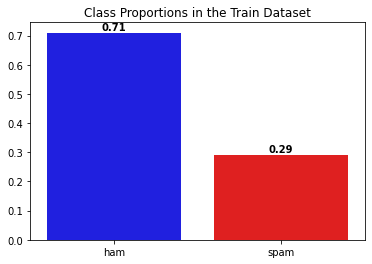

In [ ]:
y_train_flat=y_train.reshape(-1)
y_train_series = pd.Series(y_train_flat)

class_prop = y_train_series.value_counts(normalize=True)
ax=sns.barplot(x=class_prop.index, y=class_prop.values, palette=['blue', 'red'])
for i, v in enumerate(class_prop.values):
    ax.text(i, v + 0.01, str(round(v, 2)), ha='center', fontweight='bold')
plt.title('Class Proportions in the Train Dataset');


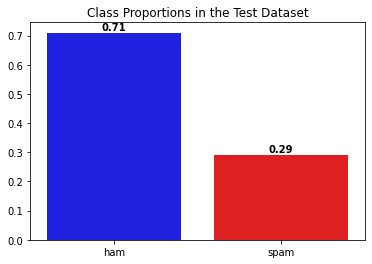

In [ ]:
y_test_flat=y_test.reshape(-1)
y_test_series = pd.Series(y_test_flat)


class_prop = y_test_series.value_counts(normalize=True)
ax=sns.barplot(x=class_prop.index, y=class_prop.values, palette=['blue', 'red'])
for i, v in enumerate(class_prop.values):
    ax.text(i, v + 0.01, str(round(v, 2)), ha='center', fontweight='bold')
plt.title('Class Proportions in the Test Dataset');


###As we can confirm no Bias was introduced in the Split process, the proportion from the original dataset was mantained.

#Feature Extraction.

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/nlp.jpg">

####The approach chosed is TfidfVectorizer. In this bag-of-words representation each document is represented as a vector of term frequencies (TF) weighted by their inverse document frequency (IDF). Lower weights are given to common words, rare receive higher weights.

In [ ]:
#Back to dataframe format
X_train= pd.DataFrame(X_train,columns=['message'])
X_test= pd.DataFrame(X_test,columns=['message'])

In [ ]:
text = X_train.message

# Cria o vetorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajusta o vetorizador ao conjunto de dados
vectorizer.fit(text)

# Codifica todos os documentos em uma matriz TF-IDF
X_train_tfidf = vectorizer.transform(text)

# Converte a matriz esparsa em uma matriz densa
X_train_dense = X_train_tfidf.toarray()

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/eda.jpg">

###In the EDA stage we will check the most repeated words in both groups and also the distribution using Boxsplots

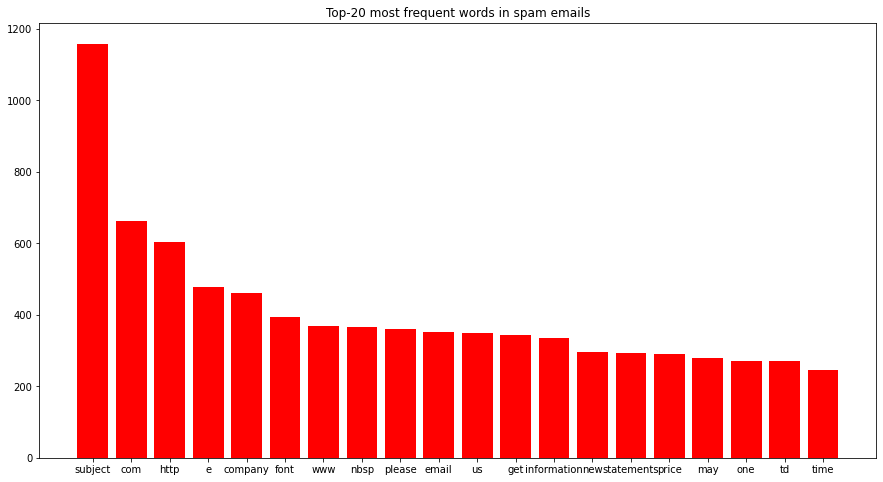

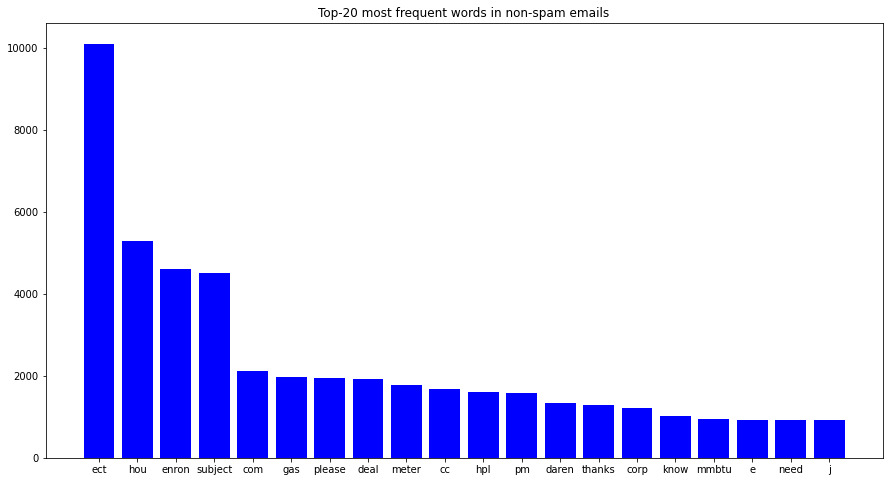

In [ ]:
stop_words = set(stopwords.words('english'))

# Separate the train data into spam and non-spam categories
spam = X_train[y_train == 'spam']
non_spam=X_train[y_train == 'ham']
# Tokenize and normalize the text data
spam_words = []
for message in spam['message']:
    words = word_tokenize(message.lower())
    spam_words += [word for word in words if word.isalpha() and word not in stop_words]

non_spam_words = []
for message in non_spam['message']:
    words = word_tokenize(message.lower())
    non_spam_words += [word for word in words if word.isalpha() and word not in stop_words]

# Count the frequency of each token in each category
spam_word_freq = nltk.FreqDist(spam_words)
non_spam_word_freq = nltk.FreqDist(non_spam_words)

# Create a dictionary that maps each token to its frequency
spam_top_words = dict(spam_word_freq.most_common(20))
non_spam_top_words = dict(non_spam_word_freq.most_common(20))

# Sort the dictionary in descending order of the frequency
spam_top_words = {k: v for k, v in sorted(spam_top_words.items(), key=lambda item: item[1], reverse=True)}
non_spam_top_words = {k: v for k, v in sorted(non_spam_top_words.items(), key=lambda item: item[1], reverse=True)}

# Create a bar plot to show the relative frequencies
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.bar(range(len(spam_top_words)), list(spam_top_words.values()), align='center', color='red')
plt.xticks(range(len(spam_top_words)), list(spam_top_words.keys()))
plt.title('Top-20 most frequent words in spam emails')
plt.show()
plt.figure(figsize=(15,8))
plt.bar(range(len(non_spam_top_words)), list(non_spam_top_words.values()), align='center', color='blue')
plt.xticks(range(len(non_spam_top_words)), list(non_spam_top_words.keys()))
plt.title('Top-20 most frequent words in non-spam emails')
plt.show()

In [ ]:
spam.loc[spam_length == spam_outlier_value]

,message
3534,"Subject: we ' ve got your info by internet , h..."


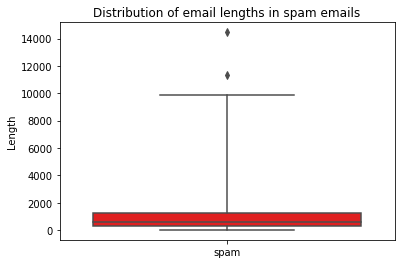

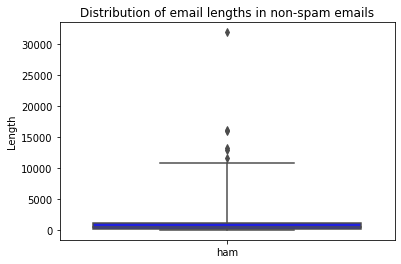

In [ ]:
# Compute the length of each message
spam_length = spam['message'].apply(len)
non_spam_length = non_spam['message'].apply(len)

# Create a boxplot to show the distribution of email lengths
sns.boxplot(x=y_train[y_train=="spam"], y=spam_length, color='red', whis=10)
plt.title('Distribution of email lengths in spam emails')
plt.ylabel('Length')
plt.show()

sns.boxplot(x=y_train[y_train=="ham"], y=non_spam_length, color='blue', whis=10)
plt.title('Distribution of email lengths in non-spam emails')
plt.ylabel('Length')
plt.show()

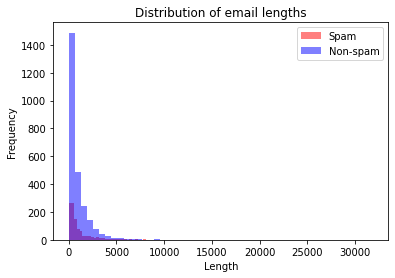

In [ ]:
# Compute the length of each message
spam_length = spam['message'].apply(len)
non_spam_length = non_spam['message'].apply(len)

# Create histograms to show the distribution of email lengths
plt.hist(spam_length, bins=50, color='red', alpha=0.5)
plt.hist(non_spam_length, bins=50, color='blue', alpha=0.5)
plt.title('Distribution of email lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(['Spam', 'Non-spam'])
plt.show()


##On Average the emails classified as Non-spam are bigger

###Now Let's examine inside the highest values(out-liers) for either Spam and Non-Spam:

In [ ]:
# Get the index of the message with the highest spam_length
max_spam_length_index = spam_length.idxmax()

# Get the value of y_train at the index with the highest spam_length
max_spam_length_category = y_train[max_spam_length_index]

# Print the content of the message with the highest spam_length
X_train.iloc[max_spam_length_index].message

"Subject: we ' ve got your info by internet , hope to cooperate .\nhtml\nhead\ntitlechina inflatables / title\nmeta http - equiv = content - type content = text / html ; charset = gb 2312\n/ head\nbody bgcolor = # e 7 f 7 ff text = # 000000 topmargin = 0\ndiv align = center\ncenter\ntable border = 0 width = 422 heiht = 90 % cellspacing = 0 cellpadding = 0 height = 1 style = border - collapse : collapse bordercolor = # 111111\ntr\ntd width = 422 height = 10 valign = middle style = line - height : 15 pt ; font - family : knle ; font - size : 9 pt colspan = 8\n/ td\n/ tr\ntr\ntd width = 68 height = 11 valign = middle style = line - height : 15 pt ; font - family : knle ; font - size : 9 pt rowspan = 3\np align = center\na href = http : / / www . china - itoy . com\nimg border = 0 src = http : / / www . china - itoy . com / email / logo . jpg width = 60 height = 60 align = left / a / td\ntd width = 354 height = 3 valign = middle style = line - height : 15 pt ; font - family : knle ; font -

In [ ]:
# Get the index of the message with the highest spam_length
max_non_spam_length_index = non_spam_length.idxmax()

# Get the value of y_train at the index with the highest spam_length
max_non_spam_length_category = y_train[max_non_spam_length_index]

# Print the content of the message with the highest spam_length
X_train.iloc[max_non_spam_length_index].message

'Subject: fw : " red , white and blue out "\n- - - - - original message - - - - -\nfrom : carter , rhonda [ mailto : rcarter @ cooperinst . org ]\nsent : friday , september 14 , 2001 12 : 33 pm\nto : \' al _ abbott @ compuserve . com \' ; \' mabner @ sprintmail . com \' ;\n\' aggiebob @ hotmail . com \' ; \' adamsck @ flash . net \' ; \' gadams @ promus . com \' ;\n\' pjadell @ yahoo . com \' ; \' bob @ cybersitebuilders . com \' ;\n\' worml 998 @ hotmail . com \' ; \' janie . beth @ prodigy . net \' ; \' gakin @ mccarthy . com \' ;\n\' vja @ flash . net \' ; \' locke . alder @ gte . net \' ; \' calexaol @ 7 - 11 . com \' ;\n\' erika @ publish . no . irs . gov \' ; \' ali @ buz . net \' ; \' brada @ ticnet . com \' ;\n\' svallen @ aol . com \' ; \' jand 30 @ aol . com \' ; \' allan @ stratsolgroup . com \' ;\n\' chuck _ anderson @ oxy . com \' ; \' mdqsga 96 @ aol . com \' ;\n\' brian _ anhalt @ bigfoot . com \' ; \' aranda @ nbstx . com \' ; \' aggiemom @ archer . cx \' ;\n\' jard @ n

###Interesting to note that in the malitious message mos of the words are in the body of the email and there's plenty of links and HTML code, meanwhile in the regular message most of the words are email addresses there are in the "TO:" part of the message.

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/sup.jpg">

##Naive Bayes </br> <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/naive.jpg">

In [ ]:
# Cria o modelo de classificação Naive Bayes
#model =sklearn.naive_bayes.GaussianNB()

# Treina o modelo com os dados codificados
#model.fit(X_train_dense, y_train)

# Avalia o modelo em dados de teste
#X_test_tfidf = vectorizer.transform(X_test.message)
#X_test_dense = X_test_tfidf.toarray()
#y_pred = model.predict(X_test_dense)
#accuracy = (y_pred == y_test).mean()

<img src="https://github.com/orlandojrps/spam/blob/main/matrix.png?raw=true">

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from sklearn.model_selection import cross_val_score
# Encode the text features using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.message)
X_train_dense = X_train_tfidf.toarray()

# Train the Naive Bayes classifier
model = GaussianNB()
model.fit(X_train_dense, y_train)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model.predict(X_test_dense)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Print the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[1077   25]
 [  35  415]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.98      0.97      1102
        spam       0.94      0.92      0.93       450

    accuracy                           0.96      1552
   macro avg       0.96      0.95      0.95      1552
weighted avg       0.96      0.96      0.96      1552



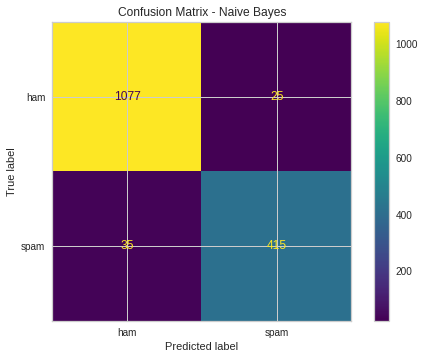

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model, X_test_dense, y_test)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/errors.png">

In [ ]:
# False Positives: Type 1 error
fp = conf_matrix[0,1]

# False negatives: Type 2 error
fn = conf_matrix[1,0]

print(f"Type 1 errors: {fp}")
print(f"Type 2 errors: {fn}")

Type 1 errors: 25
Type 2 errors: 35


<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/pickle.png">

In [ ]:
# Save the model to disk using the pickle module
filename = 'spam_classifier_model_naive.sav'
pickle.dump(model, open(filename, 'wb'))  

###Approach using Cross Fold Validation  <br>                                    <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/kfold2.png">

In [ ]:
vectorizer = TfidfVectorizer()
# Convert the DataFrame to a numpy array for cross-validation
X = df.message.values
y = df.classification.values

# Transform the text features to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X)
X_dense = X_tfidf.toarray()

# Train the Naive Bayes classifier using 10-fold cross-validation
model = GaussianNB()
scores = cross_val_score(model, X_dense, y, cv=10)

# Print the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.95945946 0.94015444 0.95551257 0.96324952 0.94970986 0.93810445
 0.95357834 0.95551257 0.96131528 0.95744681]
Mean cross-validation score: 0.9534043300000746


##Logistic Regression <br/> <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/lr.jpg">

In [ ]:
# Train the logistic regression classifier
model_LR = LogisticRegression()
model_LR.fit(X_train_dense, y_train)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_LR.predict(X_test_dense)
accuracy = (y_pred == y_test).mean()

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
# Print the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[1082   20]
 [  10  440]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1102
        spam       0.96      0.98      0.97       450

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552



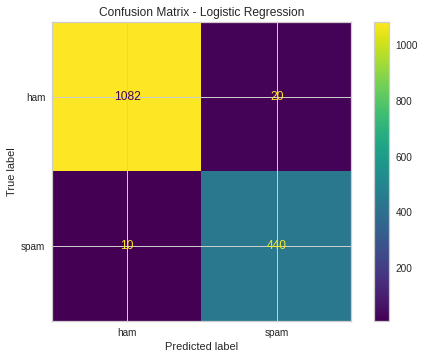

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model_LR, X_test_dense, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/errors.png">

In [ ]:
# False Positives: Type 1 error
fp = conf_matrix[0,1]

# False negatives: Type 2 error
fn = conf_matrix[1,0]

print(f"Type 1 errors: {fp}")
print(f"Type 2 errors: {fn}")

Type 1 errors: 20
Type 2 errors: 10


###Approach using Cross Fold Validation  <br>                                    <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/kfold2.png">

In [ ]:
# Encode the text features using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Convert the DataFrame to a numpy array for cross-validation
X = df.message.values
y = df.classification.values

# Transform the text features to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X)
X_dense = X_tfidf.toarray()

# Train the logistic regression classifier using 10-fold cross-validation
model_LR = LogisticRegression()
scores = cross_val_score(model_LR, X_dense, y, cv=10)

# Print the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Train the logistic regression classifier on the entire dataset
model_LR.fit(X_dense, y)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_LR.predict(X_test_dense)
accuracy = (y_pred == y_test).mean()
print('Test accuracy:', accuracy)

Cross-validation scores: [0.98455598 0.98069498 0.97485493 0.99226306 0.98065764 0.99419729
 0.98646035 0.98259188 0.9787234  0.98259188]
Mean cross-validation score: 0.9837591390782879
Test accuracy: 0.5871605643532788


##Decision Tree <br/> <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/decision_tree.png">

In [ ]:
# Train the decision tree classifier
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train_dense, y_train)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_DT.predict(X_test_dense)

In [ ]:
# Print the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1039   63]
 [  39  411]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.94      0.95      1102
        spam       0.87      0.91      0.89       450

    accuracy                           0.93      1552
   macro avg       0.92      0.93      0.92      1552
weighted avg       0.94      0.93      0.93      1552



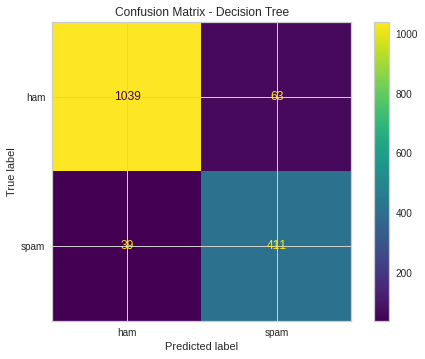

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model_DT, X_test_dense, y_test)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/errors.png">

In [ ]:
# False Positives: Type 1 error
fp = conf_matrix[0,1]

# False negatives: Type 2 error
fn = conf_matrix[1,0]

print(f"Type 1 errors: {fp}")
print(f"Type 2 errors: {fn}")

Type 1 errors: 63
Type 2 errors: 39


###Approach using Cross Fold Validation  <br>                                    <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/kfold2.png">

In [ ]:
# Encode the text features using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Convert the DataFrame to a numpy array for cross-validation
X = df.message.values
y = df.classification.values

# Transform the text features to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X)
X_dense = X_tfidf.toarray()

# Train the decision tree classifier using 10-fold cross-validation
model_DT = DecisionTreeClassifier()
scores = cross_val_score(model_DT, X_dense, y, cv=10)

# Print the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Train the decision tree classifier on the entire dataset
model_DT.fit(X_dense, y)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_DT.predict(X_test_dense)
accuracy = (y_pred == y_test).mean()
print('Test accuracy:', accuracy)

Cross-validation scores: [0.93629344 0.93822394 0.9516441  0.94390716 0.9516441  0.95357834
 0.94003868 0.93617021 0.95938104 0.93810445]
Mean cross-validation score: 0.9448985459623758
Test accuracy: 0.5882433042831332


##Random Forest <br/> <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/rf.png">

In [ ]:
# Train the random forest classifier
model_RF = RandomForestClassifier()
model_RF.fit(X_train_dense, y_train)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_RF.predict(X_test_dense)


<ipython-input-402-fc6d66c76c6c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
# Print the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1083   19]
 [  21  429]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1102
        spam       0.96      0.95      0.96       450

    accuracy                           0.97      1552
   macro avg       0.97      0.97      0.97      1552
weighted avg       0.97      0.97      0.97      1552



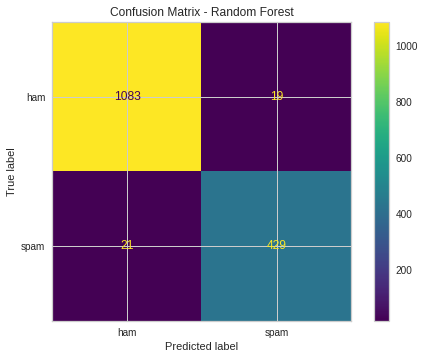

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model_RF, X_test_dense, y_test)
plt.title("Confusion Matrix - Random Forest")
plt.show()

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/errors.png">

In [ ]:
# False Positives: Type 1 error
fp = conf_matrix[0,1]

# False negatives: Type 2 error
fn = conf_matrix[1,0]

print(f"Type 1 errors: {fp}")
print(f"Type 2 errors: {fn}")

Type 1 errors: 19
Type 2 errors: 21


###Approach using Cross Fold Validation  <br>                                    <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/kfold2.png">

In [ ]:
# Encode the text features using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Convert the DataFrame to a numpy array for cross-validation
X = df.message.values
y = df.classification.values

# Transform the text features to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X)
X_dense = X_tfidf.toarray()

# Train the random forest classifier using 10-fold cross-validation
model_RF = RandomForestClassifier()
scores = cross_val_score(model_RF, X_dense, y, cv=10)

# Print the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Train the random forest classifier on the entire dataset
model_RF.fit(X_dense, y)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_RF.predict(X_test_dense)
accuracy = (y_pred == y_test).mean()
print('Test accuracy:', accuracy)

Cross-validation scores: [0.97297297 0.96718147 0.96711799 0.98259188 0.98452611 0.98452611
 0.98452611 0.9729207  0.9729207  0.96711799]
Mean cross-validation score: 0.9756402022359468
Test accuracy: 0.5882433042831332


##KNN <br/> <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/KNN.jpg">

In [ ]:

# Train the KNN classifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_dense, y_train)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_knn.predict(X_test_dense)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
# Print the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1091   11]
 [  51  399]]

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      0.99      0.97      1102
        spam       0.97      0.89      0.93       450

    accuracy                           0.96      1552
   macro avg       0.96      0.94      0.95      1552
weighted avg       0.96      0.96      0.96      1552



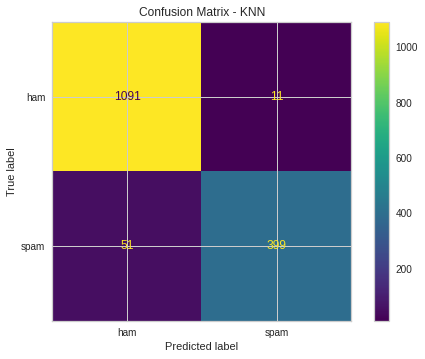

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(model_knn, X_test_dense, y_test)
plt.title("Confusion Matrix - KNN")
plt.show()

<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/errors.png">

In [ ]:
# False Positives: Type 1 error
fp = conf_matrix[0,1]

# False negatives: Type 2 error
fn = conf_matrix[1,0]

print(f"Type 1 errors: {fp}")
print(f"Type 2 errors: {fn}")

Type 1 errors: 11
Type 2 errors: 51


###Approach using Cross Fold Validation  <br>                                    <img src="https://raw.githubusercontent.com/orlandojrps/spam/main/kfold2.png">

In [ ]:
# Encode the text features using the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Convert the DataFrame to a numpy array for cross-validation
X = df.message.values
y = df.classification.values

# Transform the text features to a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(X)
X_dense = X_tfidf.toarray()

# Train the KNN classifier using 10-fold cross-validation
model_knn = KNeighborsClassifier()
scores = cross_val_score(model_knn, X_dense, y, cv=10)

# Print the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Train the KNN classifier on the entire dataset
model_knn.fit(X_dense, y)

# Evaluate the classifier on the test data
X_test_tfidf = vectorizer.transform(X_test.message)
X_test_dense = X_test_tfidf.toarray()
y_pred = model_knn.predict(X_test_dense)
accuracy = (y_pred == y_test).mean()
print('Test accuracy:', accuracy)

Cross-validation scores: [0.96332046 0.96525097 0.94777563 0.96324952 0.95938104 0.94390716
 0.95551257 0.96905222 0.96131528 0.95744681]
Mean cross-validation score: 0.9586211660679747
Test accuracy: 0.594469058879796


###Models Summary

In [ ]:
print("Training accuracy Naive Bayes:", model.score(X_test_dense,y_test), "\n")
print("Training accuracy Logistic Regression:", model_LR.score(X_test_dense,y_test), "\n")
print("Training accuracy Decision Tree:", model_DT.score(X_test_dense,y_test), "\n")
print("Training accuracy Random Forest:", model_RF.score(X_test_dense,y_test), "\n")
print("Training accuracy KNN:", model_knn.score(X_test_dense,y_test), "\n")

Training accuracy Naive Bayes: 0.961340206185567 

Training accuracy Logistic Regression: 0.9806701030927835 

Training accuracy Decision Tree: 0.9342783505154639 

Training accuracy Random Forest: 0.9742268041237113 

Training accuracy KNN: 0.9600515463917526 



<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/nlp2.png">

##Let's try a new approach, this time using Word2Vec 

####Prepare Corpus and Process Using Spacy

In [ ]:
spacy_nlp = spacy.load("en_core_web_lg")

In [ ]:
documents = [((row[1]['classification']), \
              list(spacy_nlp(row[1]['message']).vector)) \
                  for row in PROG_BAR(df.iterrows())]

0it [00:00, ?it/s]

Disassemble the documents list to make a data frame for modelling.

In [ ]:
len(documents)

5172

In [ ]:
doc_avg_feat_vec = [d[1] for d in PROG_BAR(documents)]

fileids = [doc[0][0] for doc in documents]
cats = [doc[0] for doc in documents]

embedding_df = pd.DataFrame(doc_avg_feat_vec)
embedding_df['fileids'] = fileids
embedding_df['classif'] = cats
embedding_df

  0%|          | 0/5172 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,fileids,classif
0,-1.113892,-2.856879,0.067851,3.034670,3.519979,0.031158,0.559796,0.895515,-1.588522,-1.928259,...,-0.940512,0.628054,-0.687872,0.308398,1.504863,-1.977292,0.648575,0.137265,h,ham
1,-1.997871,-0.993733,1.066550,3.557267,4.119709,-1.146070,1.528646,2.543771,-2.620118,-1.753951,...,-3.694338,-1.881931,-0.160006,1.392673,-0.654080,-0.856430,-0.126262,-2.108260,h,ham
2,-0.777874,-1.836088,1.227407,0.692029,1.871854,-1.381338,1.330841,1.227099,-1.303687,-1.110930,...,-0.279138,-1.234978,-0.065086,0.704721,-0.621658,-2.003180,-1.037511,-0.592146,h,ham
3,-0.378876,-2.345197,1.710684,0.263419,2.076986,-1.316213,0.626700,0.457884,-1.322815,-0.933804,...,0.074630,-1.160641,0.362106,0.444450,0.606455,-0.656321,-0.804740,-0.500207,h,ham
4,-1.339615,-3.523059,3.290860,0.644499,2.800753,-0.692417,1.480541,0.472253,-0.369334,-1.549670,...,-0.471850,-1.672230,0.721191,1.180729,-1.514010,-1.308038,0.401880,-1.326748,h,ham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,-1.376452,0.579227,-2.128867,0.255497,3.546762,0.266810,0.343035,3.866165,-0.296229,-0.193909,...,0.019645,-0.165400,-1.198439,1.047175,0.501223,-0.689944,-2.520779,1.200493,s,spam
5168,-0.757229,0.250863,-1.137060,-0.152292,1.953716,-0.433933,0.643753,2.300299,-1.938761,-0.281423,...,1.205716,-1.734588,-0.657278,1.151494,0.246016,-1.083122,-2.163669,0.113734,s,spam
5169,0.144048,1.678155,-3.108294,-0.244190,2.582361,0.853664,-0.206287,3.224796,-2.908455,0.826976,...,0.618286,-0.079004,-1.117445,0.071327,-0.695799,-0.706260,-3.507935,2.186368,s,spam
5170,-0.508700,0.153947,-0.105173,0.632688,1.859814,-0.597566,0.247870,1.164315,-1.645702,-1.200339,...,0.996342,-0.859071,-0.265438,0.837072,1.035834,-0.980301,-1.083439,0.455893,s,spam


###making a copy to manipulate our dataset

In [ ]:
dataset = embedding_df.copy()

###Examine the distribution of the classification targets

In [ ]:
dataset['classif'].value_counts()

ham     3672
spam    1500
Name: classif, dtype: int64

###Extract features and target

In [ ]:
dataset

In [ ]:
# code here 
X= dataset[dataset.columns.difference(['fileids','classif'])]
y= dataset['classif']

###Split the data into a training set, a validation set, and a test set

In [ ]:
X_train, X_test, y_train, y_test \
    = sklearn.model_selection.train_test_split(X, y, random_state=0, \
                                    train_size = 0.7)

In [ ]:
y_train.shape, y_test.shape

((3620,), (1552,))

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
3459,-1.437599,0.226079,-0.450912,0.404665,3.496755,0.069425,0.284366,2.048859,-1.117320,-0.980152,...,0.231233,-0.183068,0.097590,-0.656178,-0.674150,1.264731,0.428845,-0.986330,-1.746275,0.919646
1385,-1.120867,0.508721,-0.932461,0.199652,1.349656,0.061273,0.653400,1.962002,-1.469238,-0.481587,...,-0.140135,0.275941,-0.194973,-0.964436,-0.521175,0.184465,-0.505542,-0.919019,-2.007824,0.133696
1380,-1.579733,0.501096,-2.319731,0.137719,3.580279,0.412942,0.104895,3.274560,-0.690481,-1.034186,...,-0.257978,-0.573491,-0.429924,-0.121189,-0.829141,0.837816,-0.056778,-1.387864,-2.246517,1.365276
4462,-0.520833,-0.711891,0.240603,1.142083,2.197955,-0.181643,1.368186,1.568030,-2.636975,-0.585235,...,-1.638506,1.046614,0.031370,-1.225700,-0.341996,1.383547,-1.162384,-1.036130,-1.557042,-1.181642
3840,0.198265,-1.708733,-1.760131,-0.553231,2.611292,0.277894,1.915154,0.200131,-0.957162,-0.450354,...,-1.222873,0.561924,2.265649,-0.340103,-0.758102,1.295112,-0.275847,-0.719250,-2.540278,0.980197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,-0.470910,-0.204197,-0.992584,0.301529,1.393505,0.179501,0.190252,1.128582,-0.496211,-0.318439,...,-0.042498,-0.034045,-0.007838,-0.660935,-0.229728,0.286896,-0.093739,0.140259,-0.343516,-0.207982
3264,-1.213025,-0.644864,-1.058862,1.564644,3.668147,-0.218824,0.520318,2.602430,-0.840984,-1.118595,...,-0.295590,0.139079,-0.389908,-0.325878,-0.816654,0.869295,0.328183,-0.985104,-1.220317,0.241293
1653,-1.097445,1.412502,-1.979286,-0.153758,1.891362,0.760083,-0.052114,2.501544,-1.881247,-0.004948,...,0.073947,-0.189457,-0.213446,-0.759362,-0.767308,0.420209,-0.182166,-0.414276,-2.441626,0.889603
2607,-1.831192,-1.353455,-0.005766,2.153155,2.552732,-1.142333,1.683744,2.203115,-1.750254,-1.513471,...,-1.766798,1.863239,-1.443947,-1.060487,-0.266778,1.772809,-1.075241,-1.351612,-0.495693,-0.698108


In [ ]:
y_train

3459     ham
1385     ham
1380     ham
4462    spam
3840    spam
        ... 
4931    spam
3264     ham
1653     ham
2607     ham
2732     ham
Name: classif, Length: 3620, dtype: object

###A Simple Model

In [ ]:
model_NB_V2 = KNeighborsClassifier()

In [ ]:
model_NB_V2.fit(X_train, y_train)

KNeighborsClassifier()

###Evaluating Model Performance

####Assess the performance of the model on the validation dataset

In [ ]:
# Make a set of predictions for the validation data
y_pred = model_NB_V2.predict(X_test)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9007731958762887
              precision    recall  f1-score   support

         ham       0.92      0.93      0.93      1075
        spam       0.85      0.83      0.84       477

    accuracy                           0.90      1552
   macro avg       0.89      0.88      0.88      1552
weighted avg       0.90      0.90      0.90      1552

Confusion Matrix


Predicted,ham,spam,All
True,,,
ham,1004,71,1075
spam,83,394,477
All,1087,465,1552


###Assess the performance of the model on the test dataset

In [ ]:
# Make a set of predictions for the validation data
y_pred = model_NB_V2.predict(X_test)

# Print performance details
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(sklearn.metrics.classification_report(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9007731958762887
              precision    recall  f1-score   support

         ham       0.92      0.93      0.93      1075
        spam       0.85      0.83      0.84       477

    accuracy                           0.90      1552
   macro avg       0.89      0.88      0.88      1552
weighted avg       0.90      0.90      0.90      1552

Confusion Matrix


Predicted,ham,spam,All
True,,,
ham,1004,71,1075
spam,83,394,477
All,1087,465,1552


In [ ]:
print("Training accuracy Naive Bayes V2:", model_NB_V2.score(X_test,y_test), "\n")

Training accuracy Naive Bayes V2: 0.9007731958762887 



In [ ]:
# create the transform
vectorizer = TfidfVectorizer()
# list of text documents
text2 = y_train
# tokenize and build vocab
vectorizer.fit(text2)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector_y_train = vectorizer.transform(text2)
# summarize encoded vector
print(vector_y_train.shape)
print(vector_y_train.toarray())

{'ham': 0, 'spam': 1}
[1.33200831 2.2630337 ]
(3620, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(), X_train, vector_y_train.toarray())

array([0.94751381, 0.94889503, 0.94751381, 0.95441989, 0.93508287])

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(embedding_df.iloc[:, :-2], embedding_df['classif'], test_size=0.3, random_state=3948)



In [ ]:
# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:

# Evaluate the trained model on the test set
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9626288659793815


In [ ]:
vector_y_train.shape

(3620, 2)

In [ ]:
vectorizer

TfidfVectorizer()

In [ ]:
y_tes=y_train.replace({"ham": 0, "spam": 1}, inplace=True)

In [ ]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities of the test set instances belonging to each class
y_proba = lr.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
print('ROC AUC:', roc_auc)

ROC AUC: 0.9918502267076202


In [207]:
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'XGBoost']
y_probas = []

for model in models:
    y_probas.append(model.predict_proba(X_test_dense)[:, 1])

ok


In [177]:
y_test2=y_test.replace({"ham": 0, "spam": 1})

In [ ]:
lr.predict_proba(X)

array([[8.76437403e-01, 1.23562597e-01],
       [9.99996307e-01, 3.69297813e-06],
       [9.97692458e-01, 2.30754159e-03],
       ...,
       [2.32161207e-03, 9.97678388e-01],
       [1.46411404e-03, 9.98535886e-01],
       [9.71480158e-01, 2.85198421e-02]])

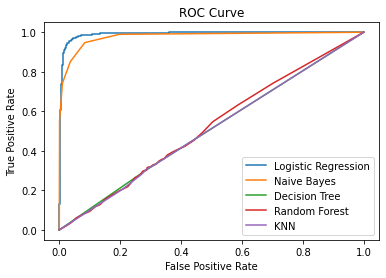

ROC AUC (Logistic Regression): 0.9918502267076202
ROC AUC (Naive Bayes): 0.9782038905952903
ROC AUC (Decision Tree): 0.5086178148310662
ROC AUC (Random Forest): 0.5194120228170249
ROC AUC (KNN): 0.5067436985032422


In [226]:
# Convert string labels to binary labels
le = LabelEncoder()
y_test_bin = le.fit_transform(y_test)

# Predict the probabilities of the test set instances belonging to each class
lr_proba = lr.predict_proba(X_test)[:, 1]
nb_proba = model_NB_V2.predict_proba(X_test)[:, 1]
dt_proba = model_DT.predict_proba(X_test_dense)[:, 1]
rf_proba = model_RF.predict_proba(X_test_dense)[:, 1]
knn_proba = model_knn.predict_proba(X_test_dense)[:, 1]

# Calculate the false positive rate and true positive rate for various thresholds
lr_fpr, lr_tpr, _ = roc_curve(y_test_bin, lr_proba)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_proba)
dt_fpr, dt_tpr, _ = roc_curve(y_test_bin, dt_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test_bin, rf_proba)
knn_fpr, knn_tpr, _ = roc_curve(y_test_bin, knn_proba)

# Plot the ROC curves for all models
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes')
plt.plot(dt_fpr, dt_tpr, label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.plot(knn_fpr, knn_tpr, label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate the ROC AUC score for all models
lr_auc = roc_auc_score(y_test, lr_proba)
nb_auc = roc_auc_score(y_test, nb_proba)
dt_auc = roc_auc_score(y_test_bin, dt_proba)
rf_auc = roc_auc_score(y_test_bin, rf_proba)
knn_auc = roc_auc_score(y_test_bin, knn_proba)

print('ROC AUC (Logistic Regression):', lr_auc)
print('ROC AUC (Naive Bayes):', nb_auc)
print('ROC AUC (Decision Tree):', dt_auc)
print('ROC AUC (Random Forest):', rf_auc)
print('ROC AUC (KNN):', knn_auc)

<img rc="https://raw.githubusercontent.com/orlandojrps/spam/main/conclusion.png">

###Conclusion: <br/>
<img src="https://raw.githubusercontent.com/orlandojrps/spam/main/conclusion.png">

###In conclusion, we can see that the models that performed better in the AUC plot were intentionally biased due to poor validation methodology to show the importance to maintain a more strict validation process, for instance K-Fold Validation